In [1]:
# Sequential model - 1.2M parameters
# 256 size conv layer with 5x5 kernel with relu activation
# 14 size max pool
# 128 size conv layer with 5x5 kernel with relu activation
# 5 size max pool layer
# 120 size fully connected layer with relu activation
# 86 size fully connected layer with relu activation
# 10 size output layer with softmax activation

# This model is saved and its initial weights are used as a baseline for other image techniques

In [2]:
# import required libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 as cv

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
from tensorflow.python.compiler.mlcompute import mlcompute

# Select processing device.
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

# Remove apple to tensorflow comparison warnings
# note these warning do not affect the model, they are removed for visual purposes
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
# measure time taken for model to run
start = time.time()

In [4]:
# create the model
model = models.Sequential()

# 256 Conv Layer
model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(32, 32, 1)))

# 14 Max Pool Layer
model.add(layers.MaxPool2D(pool_size=(2, 2), padding='valid'))

# 128 Conv Layer
model.add(layers.Conv2D(128, kernel_size=(5,5), padding='valid', activation='relu'))

# 5 Max Pool Layer
model.add(layers.MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the Layer for transitioning to the Fully Connected Layers
model.add(layers.Flatten())

# 120 Fully Connected Layer
model.add(layers.Dense(120, activation='relu'))

# 86 Fully Connected Layer
model.add(layers.Dense(86, activation='relu'))

# 10 Output
model.add(layers.Dense(10, activation='softmax'))

# model architecture
model.summary()

# save model
model.save("CNN_gray")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 256)       6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       819328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               384120    
_________________________________________________________________
dense_1 (Dense)              (None, 86)                1

/Users/ethan/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/ethan/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


In [5]:
# download dataset and initialise test/train
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
# convert images to grayscale
gray_train = np.empty((50000, 32, 32))
gray_test = np.empty((10000, 32, 32))

for index, image in enumerate(train_images):
    gray_train[index] = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)

for index, image in enumerate(test_images):
    gray_test[index] = cv.cvtColor((image * 255).astype(np.uint8),cv.COLOR_BGR2GRAY)
    
gray_train = gray_train[..., np.newaxis]
gray_test = gray_test[..., np.newaxis]

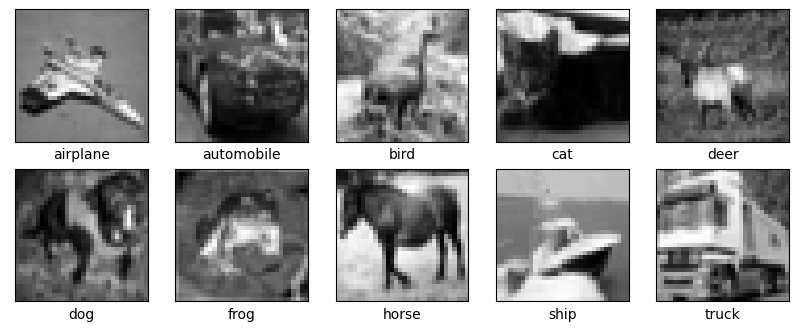

In [7]:
# verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

image_class_index = [gray_train[30], gray_train[5], gray_train[6], gray_train[9], gray_train[3],
                     gray_train[27], gray_train[0], gray_train[7], gray_train[8], gray_train[1]]

plt.figure(figsize=(10,10))
for i in range(len(image_class_index)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_class_index[i], cmap = 'gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[i])
plt.show()

In [8]:
# compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'], run_eagerly=False)

history = model.fit(gray_train, train_labels, epochs=10, 
                    validation_data=(gray_test, test_labels))

end = time.time()

Epoch 1/10
1563/1563 [==============================] - 57s 36ms/step - loss: 3.0774 - accuracy: 0.2765 - val_loss: 1.5954 - val_accuracy: 0.4392
Epoch 2/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4972 - accuracy: 0.4722 - val_loss: 1.4042 - val_accuracy: 0.5111
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.3525 - accuracy: 0.5278 - val_loss: 1.4127 - val_accuracy: 0.5165
Epoch 4/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.2358 - accuracy: 0.5717 - val_loss: 1.2917 - val_accuracy: 0.5603
Epoch 5/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.1447 - accuracy: 0.6034 - val_loss: 1.2573 - val_accuracy: 0.5710
Epoch 6/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.0616 - accuracy: 0.6303 - val_loss: 1.2516 - val_accuracy: 0.5821
Epoch 7/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.9784 - accuracy: 0.6618 - val_loss: 1.3253 -

Validation set results
313/313 - 4s - loss: 1.4210 - accuracy: 0.5831
Total time taken to classify: 9.29 minutes


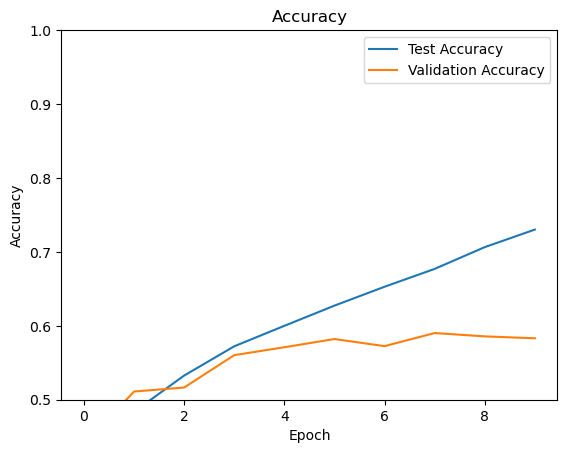

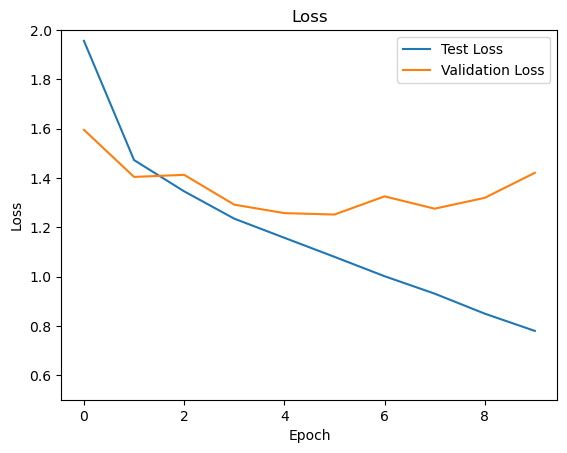

In [9]:
# test model and print results
print("Validation set results")
test_loss, test_acc = model.evaluate(gray_test, test_labels, verbose = 2)

# print total time take
minutes = (end - start) / 60
print("Total time taken to classify: {:.2f}".format(minutes), "minutes")

# Plot the accuracy
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

# Plot the loss
plt.title("Loss")
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 2])
plt.legend(loc='upper right')
plt.show()